# Bootstrap analysis of all task's subtypes

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import plotting

In [2]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [5]:
#  Set path
path_root = '/mnt/home_sq/yassinebha/data/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/pheno'
#path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno'
#mask_path = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/mask_roi_resample.nii.gz'
mask_path = '/mnt/home_sq/yassinebha/data/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/mask_roi_resample.nii.gz'

In [6]:
df_stack = pd.read_csv(os.path.join(path_root,'all_subtype_stack.csv'))

In [7]:
df_stack.head()

,EMO_contrast_fear_vs_neut_sub1,EMO_contrast_fear_vs_neut_sub2,EMO_contrast_fear_vs_neut_sub3,EMO_contrast_fear_vs_neut_sub4,EMO_contrast_fear_vs_neut_sub5,GAM_contrast_win_vs_loss_sub1,GAM_contrast_win_vs_loss_sub2,GAM_contrast_win_vs_loss_sub3,GAM_contrast_win_vs_loss_sub4,GAM_contrast_win_vs_loss_sub5,...,WM_0bk_sub1,WM_0bk_sub2,WM_0bk_sub3,WM_0bk_sub4,WM_0bk_sub5,WM_2bk_sub1,WM_2bk_sub2,WM_2bk_sub3,WM_2bk_sub4,WM_2bk_sub5
0,-0.229590,0.789998,0.256789,0.657664,-0.688034,-0.280607,-0.379255,0.684838,-0.896567,0.743033,...,1.112975,1.033061,-0.506427,0.362818,-0.921810,0.725796,0.279384,-0.077054,0.629170,-0.585860
1,-0.154963,0.394645,0.336540,0.633725,-0.606700,-0.250487,-0.328870,0.252394,-0.846275,0.917483,...,1.080058,0.970486,-0.525101,0.382929,-0.822772,0.705165,0.320632,-0.014777,0.641639,-0.609268
2,-0.059922,0.525727,0.295237,0.140892,-0.546841,-0.230613,-0.656313,0.072737,-0.382268,0.885286,...,0.993790,0.799496,-0.415839,0.303451,-0.765309,0.517658,0.301844,0.035949,0.472618,-0.471403
3,-0.295939,0.381127,0.431556,0.458956,-0.489885,-0.960959,0.475971,0.144408,-0.881855,0.977744,...,0.441557,0.566373,-0.398126,0.347071,-0.367073,0.421399,0.250358,-0.320497,0.466519,-0.338982
4,-0.288014,0.364902,0.416104,0.425780,-0.462302,-0.976032,0.543835,0.131646,-0.968926,1.016922,...,0.490695,0.517005,-0.398157,0.346950,-0.342697,0.400953,0.206851,-0.279168,0.471151,-0.338452


In [8]:
# extract all table value
y = df_stack.loc[:].values
LABELS_Y = list(df_stack.columns.values)

In [9]:
# push it to octave
%octave_push y
%octave_push LABELS_Y
%octave LABELS_Y = LABELS_Y';

We compute the spatial correlation matrix (across subjects) to see how the cluster structure looks.  

ans =  1

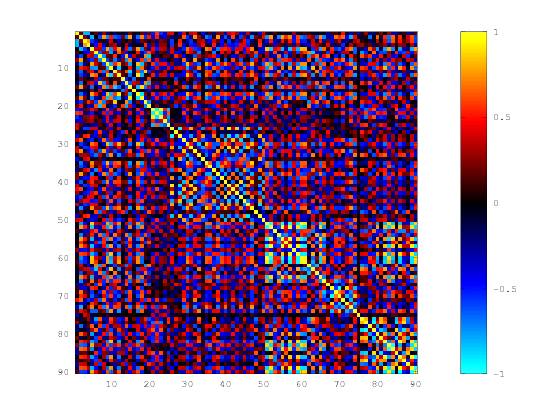

In [10]:
%%octave
nb_cluster =7;   # numb of clusters 
R = corr(y);
title('Spatial correlation matrix')
niak_visu_matrix(R), axis square

the cluster structure is clear, but noisy. Let's run a hierarchical clustering and see if we can recover it. 

     Percentage done : 0 6 10 16 20 26 30 36 40 46 51 55 61 65 71 75 81 85 91 96 100 Done ! 

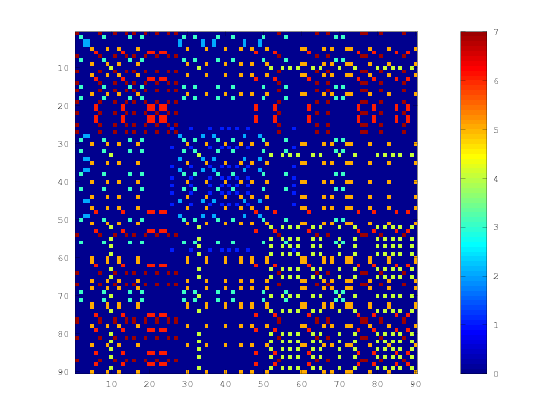

In [11]:
%%octave
hier = niak_hierarchical_clustering(R); % The similarity-based hierarchical clustering
part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); % threshold the hierarchy to get 3 clusters
niak_visu_part(part) % visualize the partition

If the clustering had done a perfect job, we would have squares on the diagonal.let's odre it

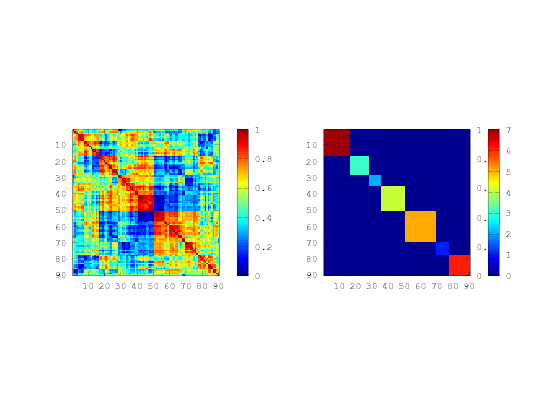

In [12]:
%%octave
order = niak_hier2order(hier); % order the regions based on the hierarchy
subplot(1,2,1)
# Re-order the correlation matrix
title('re-ordered correlation matrix')
imagesc(R(order,order)), axis square, colorbar
subplot(1,2,2)
# Show the re-ordered partition
title('re-ordered partition')
niak_visu_part(part(order)), axis square

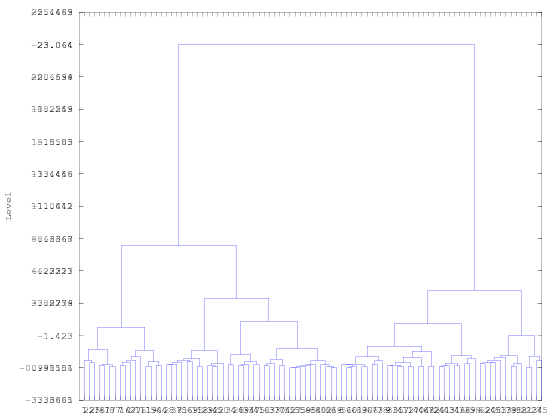

In [13]:
%octave niak_visu_dendrogram(hier)

## boostrap analysis of stable clusters
 

In [14]:
%%octave
nb_samp = 100;
opt_b.block_length = 1; # That's a parameter for the bootstrap. We treat the subjects as independent observations. 
for ss = 1:nb_samp
    niak_progress(ss,nb_samp)
    y_s = niak_bootstrap_tseries(y,opt_b); # Bootstrap the subjects
    R_s = corr(y_s); # compute the correlation matrix for the bootstrap sample
    hier = niak_hierarchical_clustering(R_s,struct('flag_verbose',false)); # replication the hierarchical clustering
    part = niak_threshold_hierarchy(hier,struct('thresh',nb_cluster)); # Cut the hierarchy to get clusters
    mat = niak_part2mat(part,true); # convert the partition into an adjacency matrix
    if ss == 1; stab = mat; else stab = stab+mat; end; # Add all adjacency matrices
end
stab = stab / nb_samp; # Divide by the number of replications to get the stability matrix

    Percentage done: 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100

In [31]:
%%octave -i path_root
save( [path_root filesep 'stability_maps_' date '.mat'],'stab')

Let's have a look at the stability matrix:

     Percentage done : 0 6 10 16 20 26 30 36 40 46 51 55 61 65 71 75 81 85 91 96 100 Done ! 

ans =  3

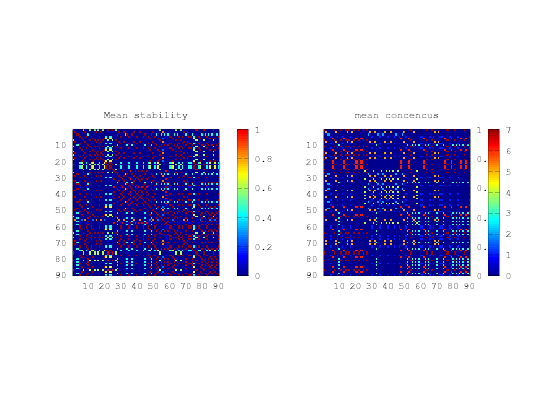

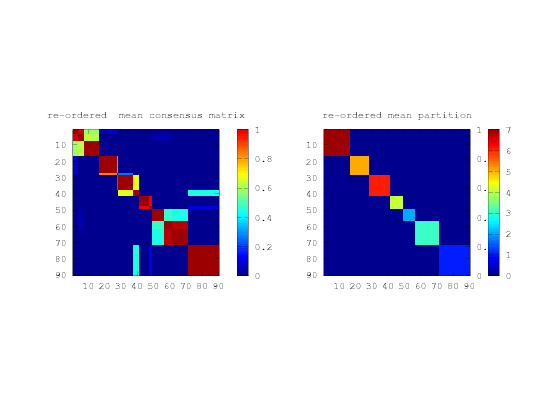

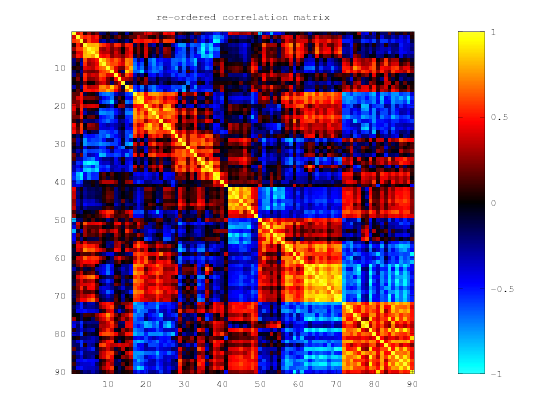

In [17]:
%%octave
subplot(1,2,1)
imagesc(stab), axis square, colormap(jet), colorbar, title('Mean stability')
nb_cluster =7;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab); # run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); # cut the consensus hierarchy
subplot(1,2,2)
niak_visu_part(part_consensus), axis square, colormap(jet),title('mean concencus') # visualize the consensus partition
order_consensus = niak_hier2order(hier_consensus); # order the regions based on the hierarchy
figure
subplot(1,2,1)
# Re-order the correlation matrix
imagesc(stab(order_consensus,order_consensus)), axis square,colorbar, title('re-ordered  mean consensus matrix')
# Show the re-ordered partition
subplot(1,2,2)
niak_visu_part(part_consensus(order_consensus)), axis square,colorbar,title('re-ordered mean partition')
# Re-order the correlation matrix
figure
subplot(1,1,1)
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar,title('re-ordered correlation matrix')

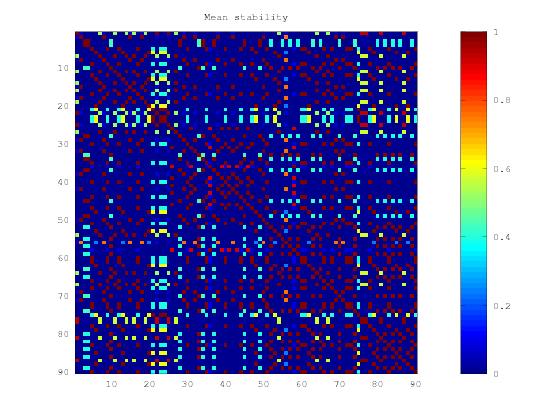

In [19]:
%octave imagesc(stab), axis square, colormap(jet), colorbar, title('Mean stability')

In [20]:
%%octave -o nb_cluster
nb_cluster =7;   % # of clusters 
hier_consensus = niak_hierarchical_clustering(stab); # run a hierarchical clustering on the stability matrix
part_consensus = niak_threshold_hierarchy(hier_consensus,struct('thresh',nb_cluster)); # cut the consensus hierarchy

     Percentage done : 0 6 10 16 20 26 30 36 40 46 51 55 61 65 71 75 81 85 91 96 100 Done ! 

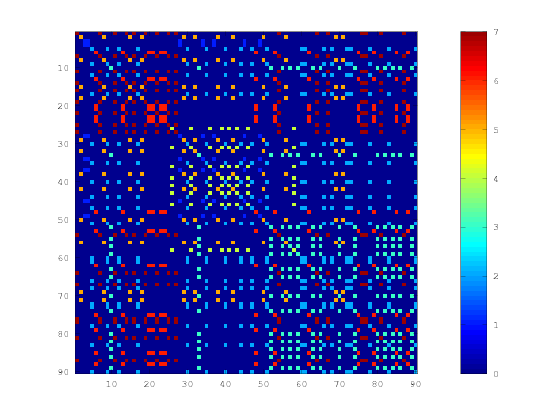

In [21]:
%octave niak_visu_part(part_consensus), axis square, colormap(jet) # visualize the consensus partition

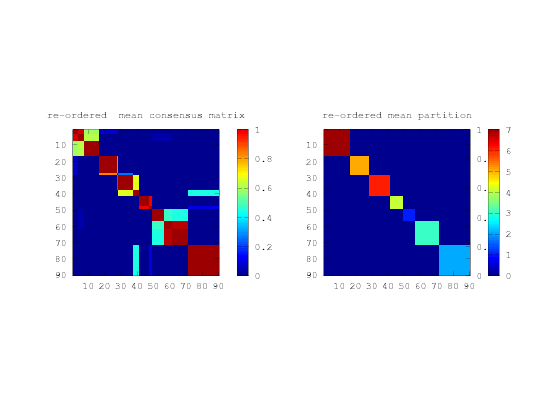

In [22]:
%%octave
order_consensus = niak_hier2order(hier_consensus); # order the regions based on the hierarchy
subplot(1,2,1)
# Re-order the correlation matrix
imagesc(stab(order_consensus,order_consensus)), axis square, colorbar, title('re-ordered  mean consensus matrix')
subplot(1,2,2)
# Show the re-ordered partition
niak_visu_part(part_consensus(order_consensus)), axis square,title('re-ordered mean partition')

In [23]:
#%octave niak_visu_dendrogram(hier_consensus)

ans =  1

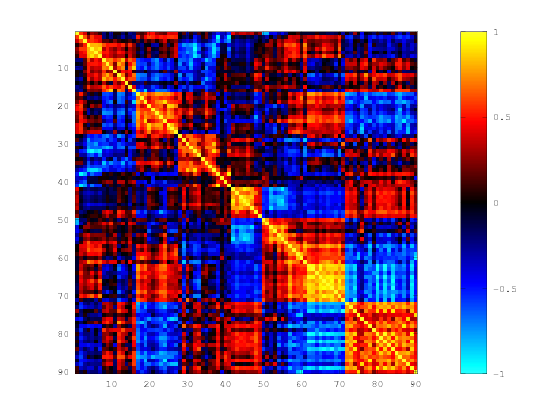

In [24]:
%%octave
# Re-order the correlation matrix
title('re-ordered correlation matrix')
niak_visu_matrix(R(order_consensus,order_consensus)), axis square, colorbar


In [25]:
%%octave -o stack
# calculate the mean cluster and save it
stack = [];
labels_y_order = LABELS_Y( order_consensus);
part_consensus_order = part_consensus(order_consensus);
y_order = y(:,order_consensus);
for ii = 1:nb_cluster
    fprintf('Cluster %i: \n',ii);
    label_y{ii} = sprintf('cluster_%i',ii);
    mask = zeros(size(part_consensus_order));
    mask = part_consensus_order == ii;
    mean_clust = mean(y_order(:,mask),2);
    stack = [stack mean_clust];
    labels_pheno = labels_y_order(mask);
    for ss = 1:size(labels_pheno)(1)
        fprintf('     %s \n',labels_pheno{ss})
    end
end

Cluster 1: 

     EMO_contrast_fear_vs_neut_sub3 

     EMO_contrast_fear_vs_neut_sub4 

     MOT_rh_sub4 

     MOT_lh_sub4 

     MOT_lf_sub5 

     MOT_rf_sub3 

     MOT_t_sub2 

Cluster 2: 

     EMO_contrast_fear_vs_neut_sub5 

     GAM_contrast_win_vs_loss_sub4 

     WM_0bk_sub3 

     SOC_contrast_mental_vs_rnd_sub2 

     MOT_lf_sub4 

     SOC_mental_sub1 

     GAM_loss_sub2 

     WM_contrast_2bk_vs_0bk_sub3 

     REL_relation_sub5 

     MOT_lh_sub5 

     REL_match_sub1 

     MOT_rf_sub5 

     WM_2bk_sub5 

     MOT_rh_sub2 

     SOC_contrast_mental_vs_rnd_sub3 

     GAM_win_sub2 

     MOT_t_sub5 

     REL_contrast_relation_vs_match_sub1 

     SOC_mental_sub3 

Cluster 3: 

     GAM_contrast_win_vs_loss_sub5 

     MOT_lh_sub3 

     SOC_contrast_mental_vs_rnd_sub4 

     SOC_mental_sub5 

     REL_contrast_relation_vs_match_sub3 

     REL_match_sub2 

     REL_match_sub5 

     WM_contrast_2bk_vs_0bk_sub5 

     REL_relation_sub2 

     WM_2bk_sub1 

     REL_relation_sub4 

     WM_2bk_sub4 

     REL_contrast_relation_vs_match_sub5 

     WM_0bk_sub2 

     WM_0bk_sub4 

Cluster 4: 

     MOT_rf_sub1 

     MOT_t_sub4 

     MOT_lh_sub1 

     MOT_lf_sub1 

     MOT_lf_sub3 

     MOT_rh_sub1 

     MOT_t_sub1 

     REL_relation_sub3 

Cluster 5: 

     EMO_contrast_fear_vs_neut_sub2 

     SOC_mental_sub4 

     GAM_loss_sub5 

     MOT_lf_sub2 

     SOC_contrast_mental_vs_rnd_sub1 

     GAM_contrast_win_vs_loss_sub3 

     MOT_t_sub3 

     GAM_win_sub3 

     MOT_lh_sub2 

     MOT_rf_sub4 

     MOT_rh_sub5 

     REL_relation_sub1 

Cluster 6: 

     GAM_contrast_win_vs_loss_sub1 

     WM_2bk_sub3 

     REL_contrast_relation_vs_match_sub2 

     WM_contrast_2bk_vs_0bk_sub4 

     REL_match_sub3 

     GAM_loss_sub3 

     GAM_win_sub5 

     MOT_rh_sub3 

     WM_0bk_sub5 

     LAN_story_sub1 

     SOC_contrast_mental_vs_rnd_sub5 

     LAN_story_sub4 

     LAN_story_sub3 

Cluster 7: 

     EMO_contrast_fear_vs_neut_sub1 

     LAN_story_sub2 

     LAN_story_sub5 

     WM_contrast_2bk_vs_0bk_sub1 

     WM_contrast_2bk_vs_0bk_sub2 

     WM_0bk_sub1 

     WM_2bk_sub2 

     GAM_contrast_win_vs_loss_sub2 

     REL_contrast_relation_vs_match_sub4 

     GAM_win_sub4 

     MOT_rf_sub2 

     REL_match_sub4 

     GAM_loss_sub4 

     GAM_win_sub1 

     SOC_mental_sub2 

     GAM_loss_sub1 

In [26]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0
print('NVoxels = {}'.format(np.sum(mask)))
print('Shape = {}'.format(mask.shape))

NVoxels = 59900
Shape = (53, 64, 52)


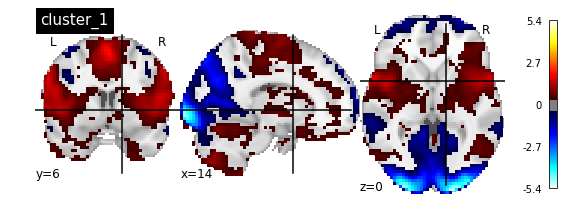

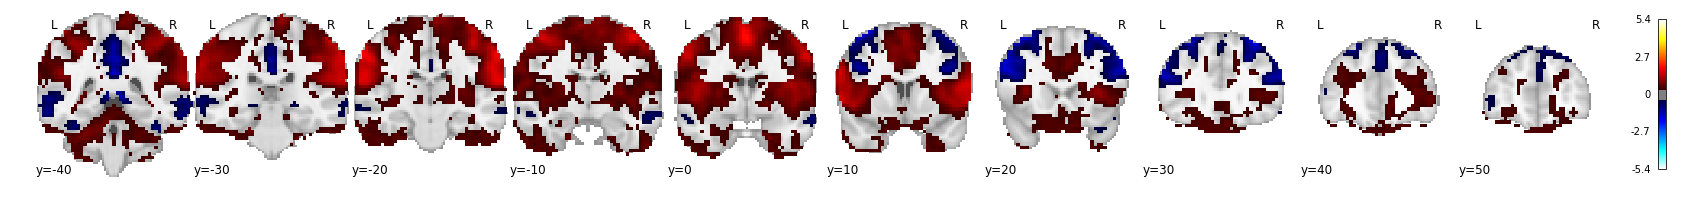

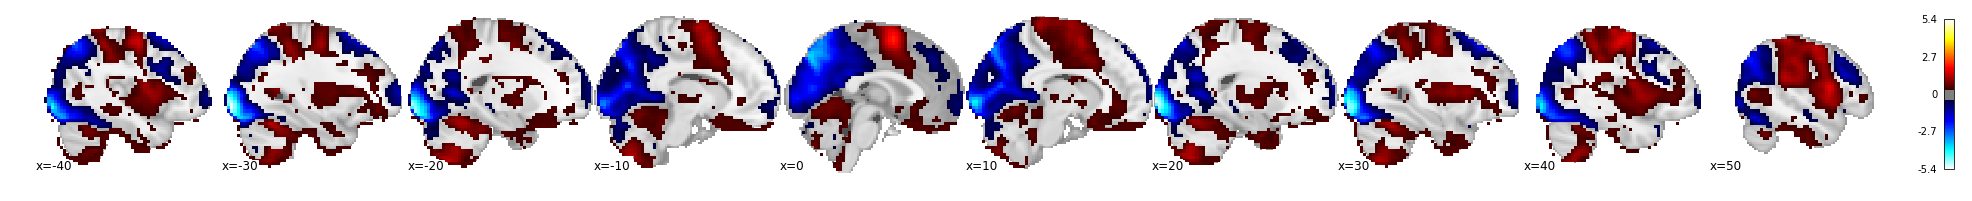

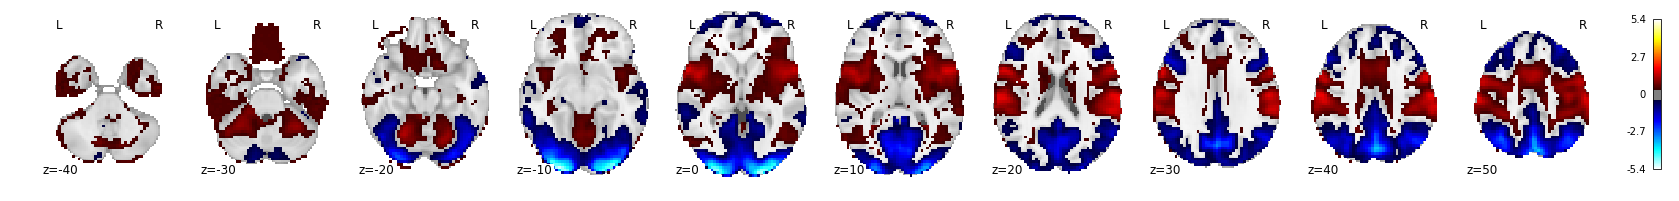

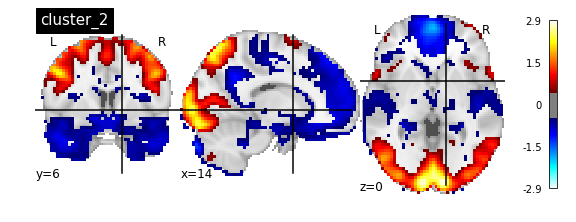

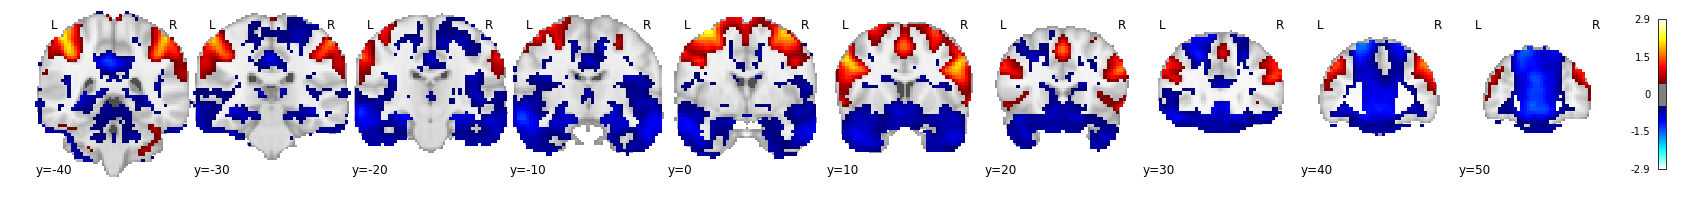

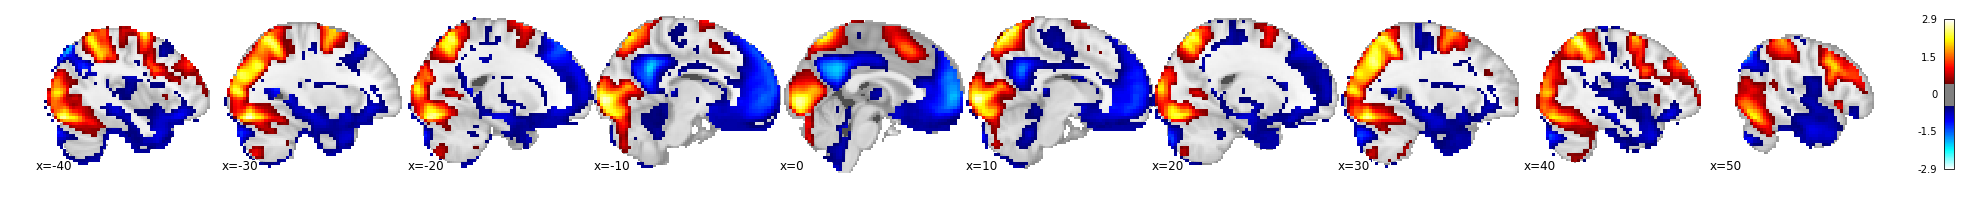

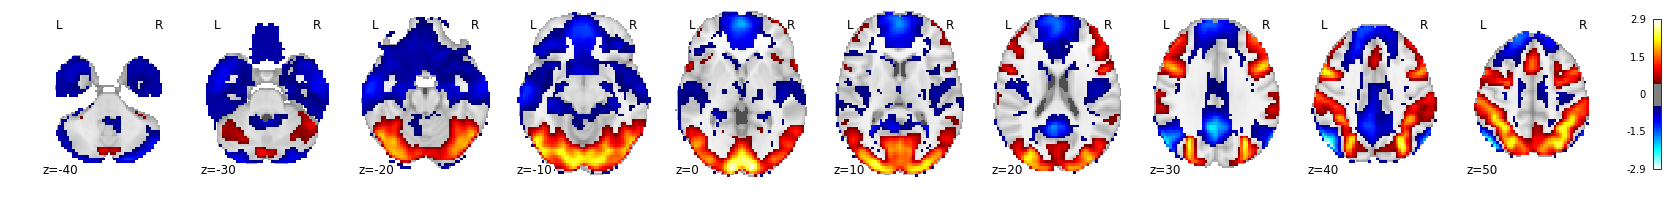

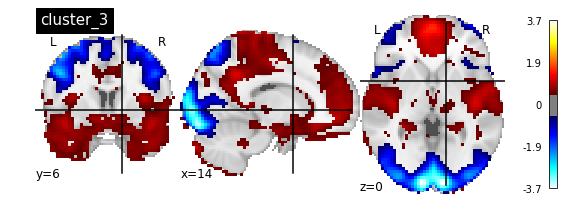

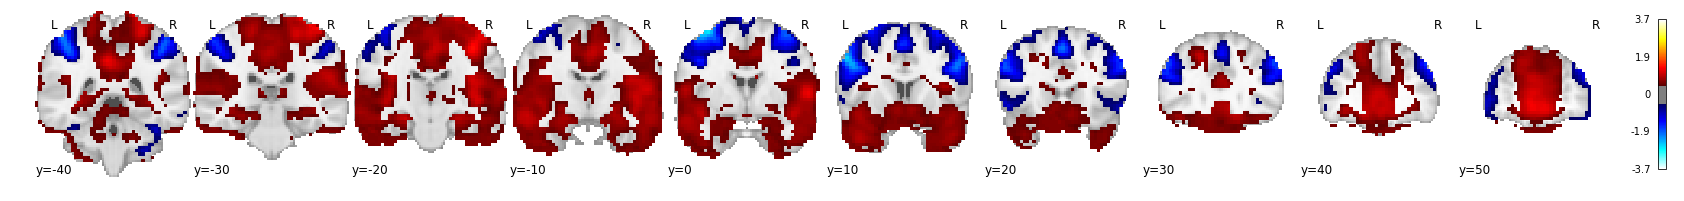

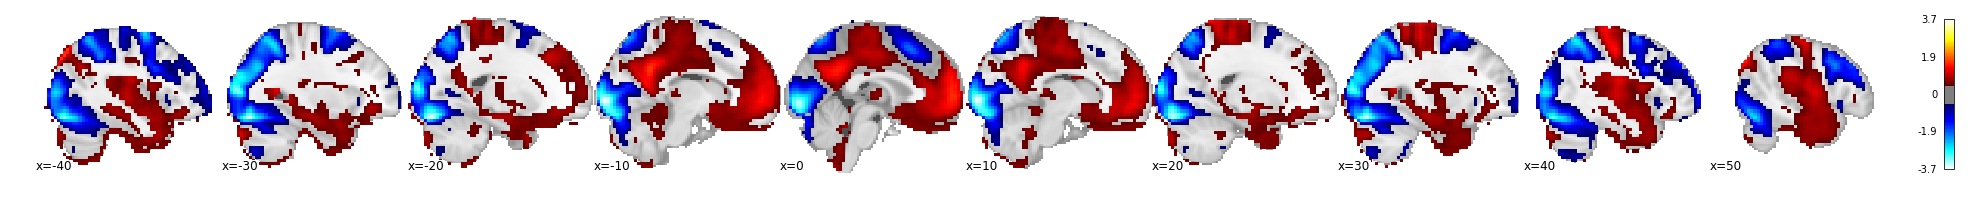

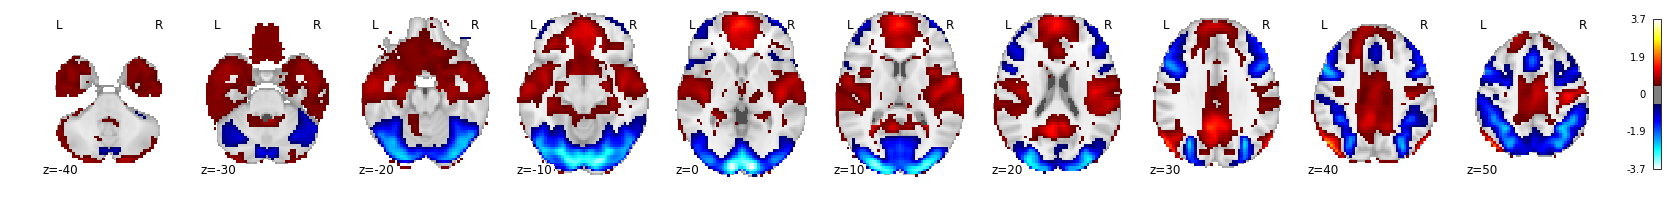

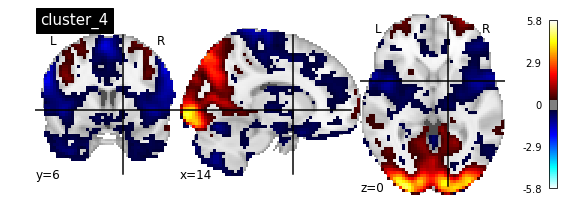

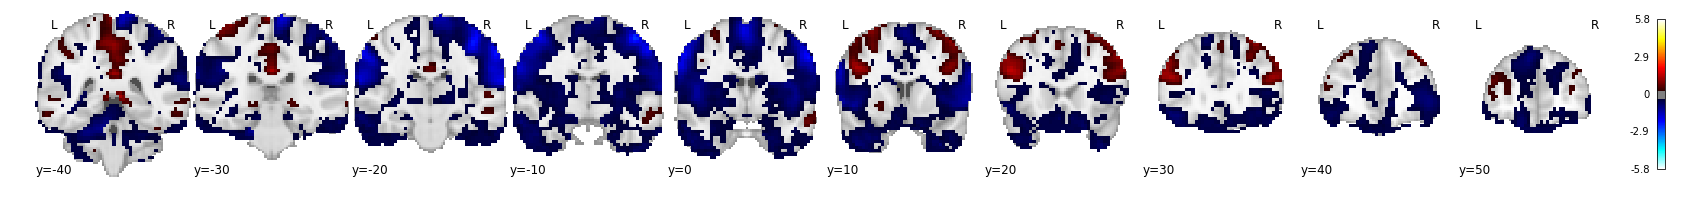

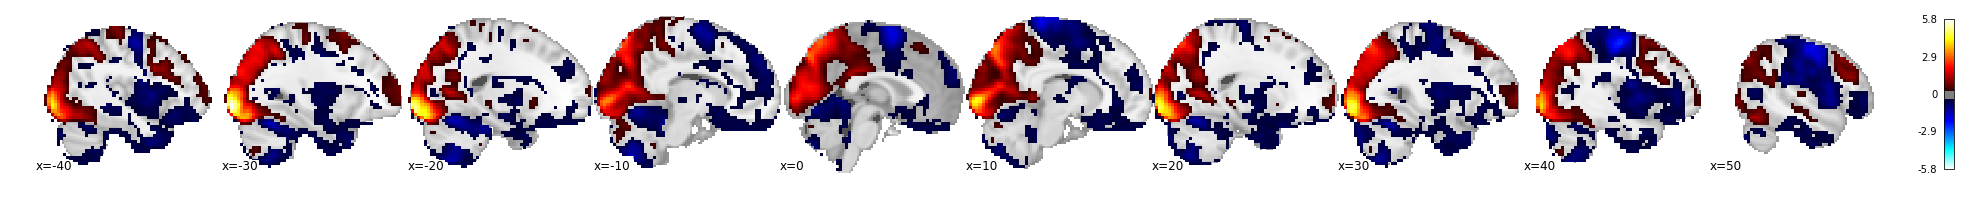

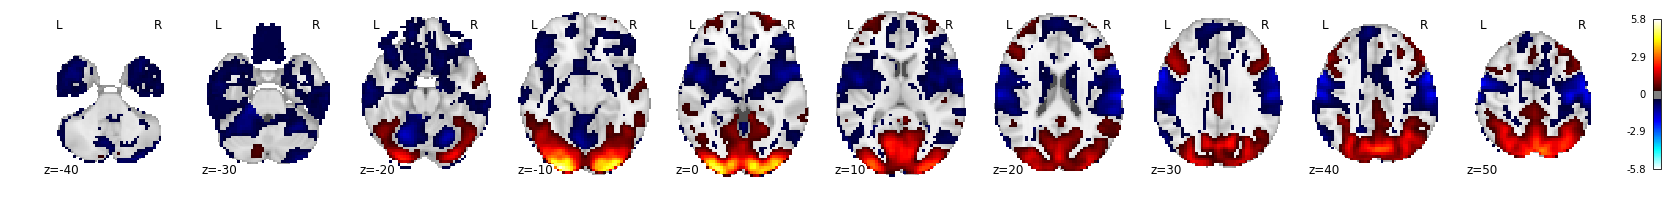

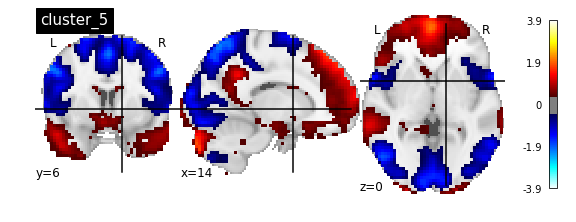

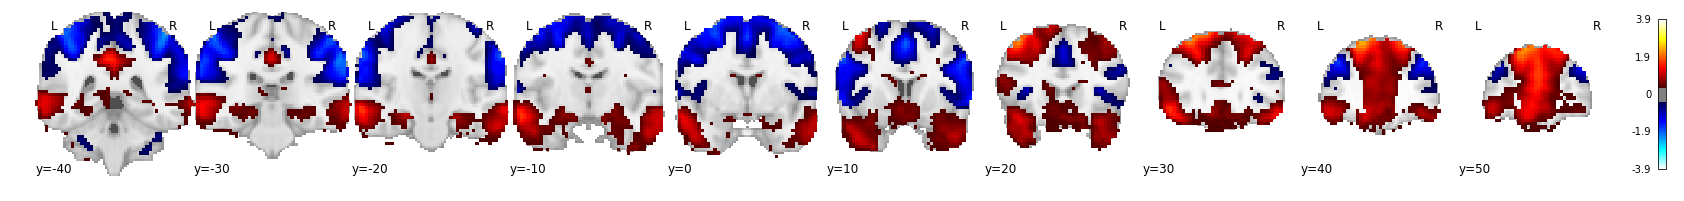

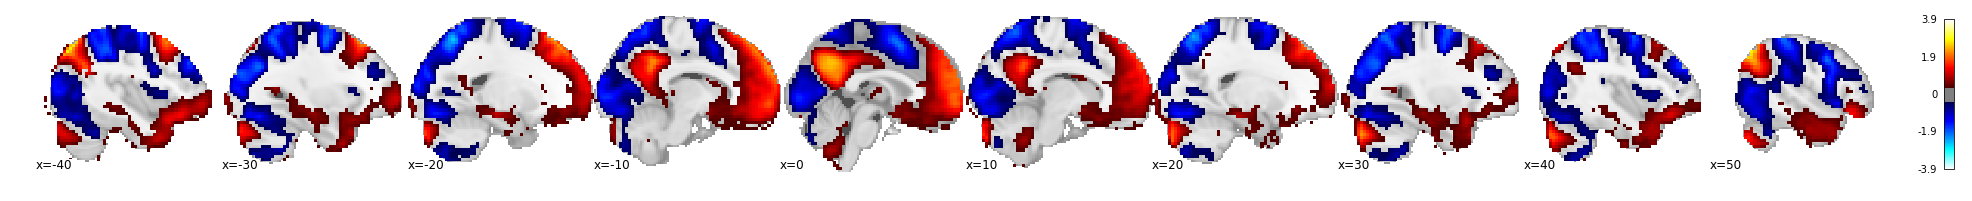

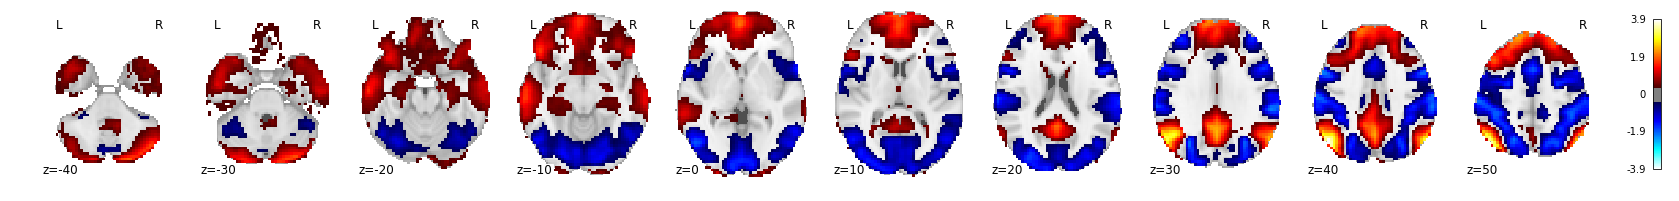

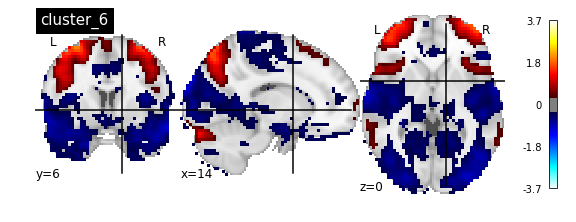

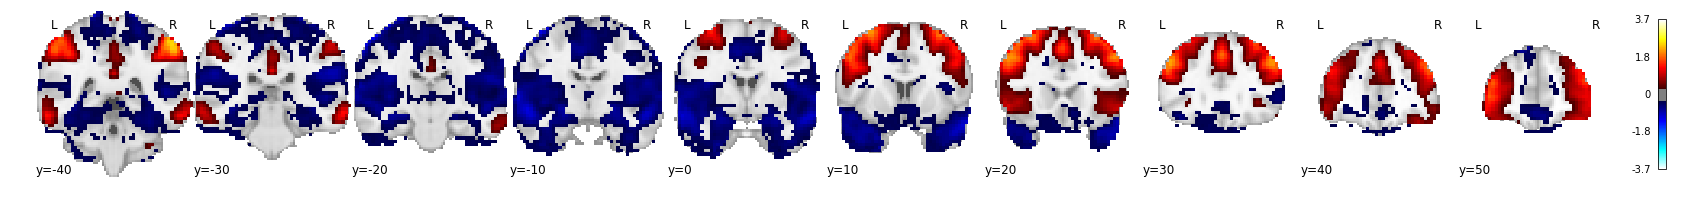

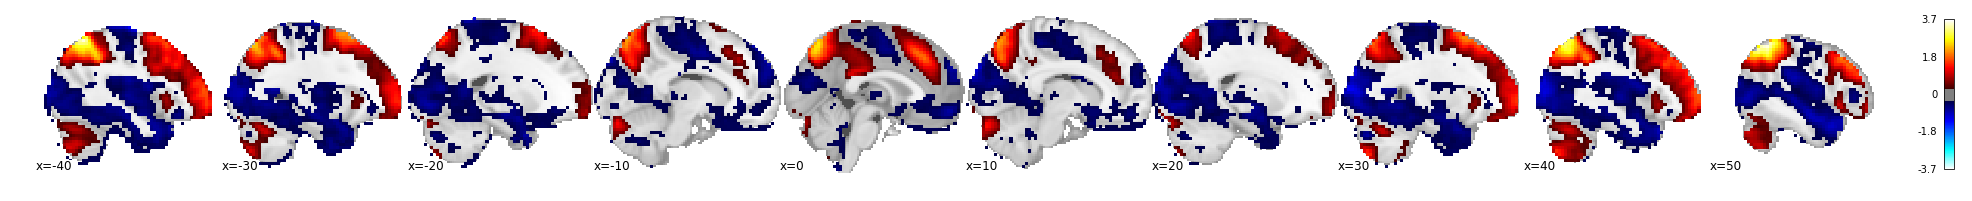

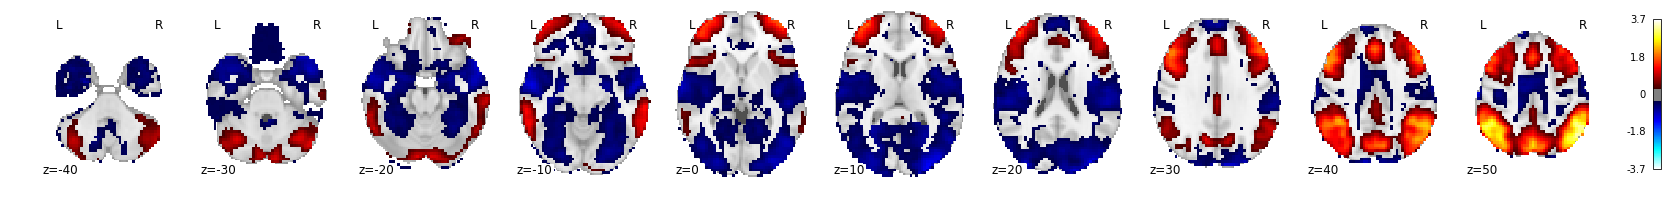

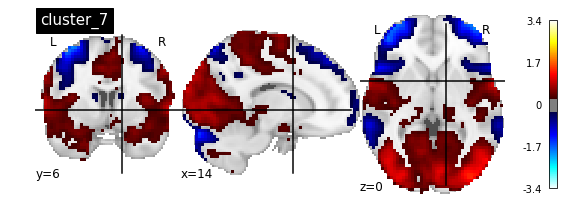

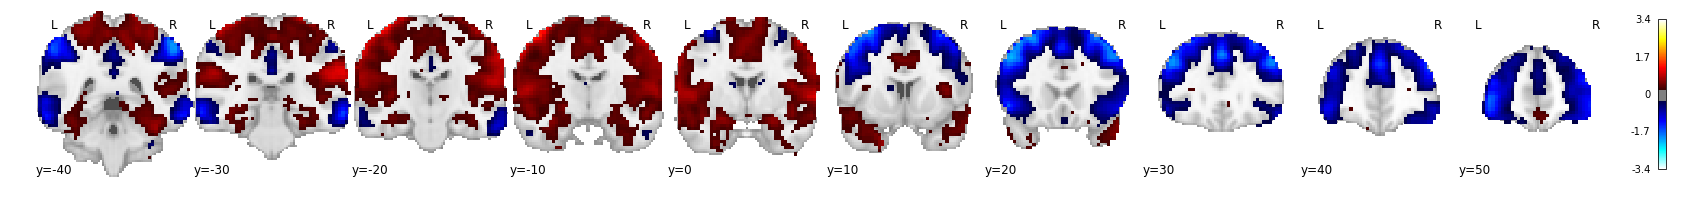

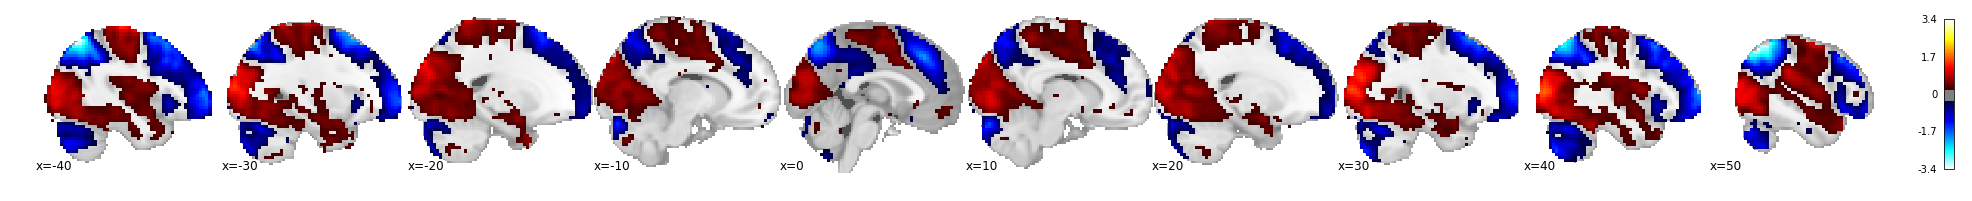

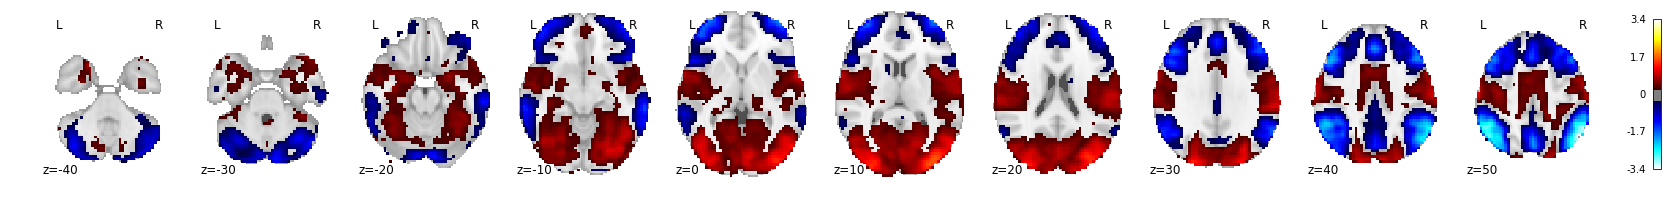

In [27]:
for cluster_num in range(int(nb_cluster)):
    sbt = stack[:,cluster_num]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    %octave_push mask sbt
    %octave vol = niak_tseries2vol(sbt,mask);
    %octave_pull vol
    sbt_img = nib.Nifti1Image(vol, affine=m_img.get_affine(), header=m_img.get_header())
    display = plotting.plot_stat_map(sbt_img,cut_coords=(14,6, 0),threshold= 'auto',
                                     title= "cluster_%s" % str(cluster_num+1))
    display = plotting.plot_stat_map(sbt_img, threshold= 'auto',
                                     display_mode='y',
                                     cut_coords= range(-40, 60, 10)
                                    )
    display = plotting.plot_stat_map(sbt_img, threshold='auto',
                                     display_mode='x',
                                     cut_coords= range(-40, 60, 10)
                                    )
    display = plotting.plot_stat_map(sbt_img, threshold='auto',
                                     display_mode='z',
                                     cut_coords= range(-40, 60, 10)
                                    )


ans =  1

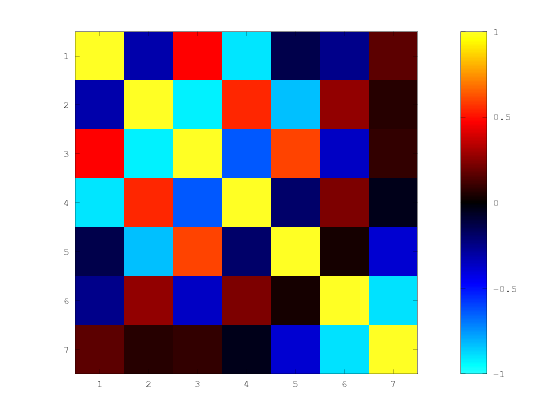

In [28]:
%%octave
Rc = corr(stack);
title('Spatial correlation matrix of clustered pheno')
niak_visu_matrix(Rc), axis square

In [35]:
%octave Rc

Rc =

   1.00000  -0.72730   0.72585  -0.68491   0.51075  -0.76960   0.53675

  -0.72730   1.00000  -0.93900   0.47451  -0.68151   0.54263  -0.19087

   0.72585  -0.93900   1.00000  -0.63232   0.46534  -0.38906   0.27679

  -0.68491   0.47451  -0.63232   1.00000   0.14231   0.10573  -0.84009

   0.51075  -0.68151   0.46534   0.14231   1.00000  -0.79651  -0.28678

  -0.76960   0.54263  -0.38906   0.10573  -0.79651   1.00000  -0.13067

   0.53675  -0.19087   0.27679  -0.84009  -0.28678  -0.13067   1.00000